# Setup


In [1]:
import pandas as pd
import numpy as np
from pandas import read_csv
from datetime import datetime
from math import sqrt
from numpy import concatenate
import matplotlib.pyplot as plt
import datetime
import math
import seaborn

In [2]:
pip install metpy

     |████████████████████████████████| 327kB 5.0MB/s 
     |████████████████████████████████| 215kB 15.1MB/s 
     |████████████████████████████████| 51kB 6.6MB/s 


In [3]:
import metpy.calc as mpcalc

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Data

In [5]:
# Load CSV data file

Data_all = pd.read_csv('/content/drive/My Drive/Grad School/Stanford - Q4 2020-2021/CEE 263C/Term Paper/Data/NOAA_2018_north_all.csv')

In [6]:
# Checking data imported correctly

print(len(Data_all))
Data_all.head()

2913


,time (UTC),latitude (degrees_north),longitude (degrees_east),tmpsfc (K),tmp2m (K),ugrd10m (m s-1),vgrd10m (m s-1),pratesfc (kg m-2 s-1),rh2m (%),prmslmsl (Pa),dlwrfsfc (W m-2),dswrfsfc (W m-2)
0,2018-01-01T12:00:00Z,38.0,58.0,287.87296,289.52072,-1.654617,0.965122,NaN,19.307024,101252.050,NaN,NaN
1,2018-01-01T15:00:00Z,38.0,58.0,282.30330,285.71680,0.030881,1.948872,0.0,23.900000,101214.586,282.00000,10.0
2,2018-01-01T18:00:00Z,38.0,58.0,280.58080,284.64194,0.507683,2.110371,0.0,24.100000,101047.586,276.63098,10.0
3,2018-01-01T21:00:00Z,38.0,58.0,279.59222,284.16950,0.835078,2.283294,0.0,23.300001,100830.130,269.90836,0.0
4,2018-01-02T00:00:00Z,38.0,58.0,279.38390,284.28410,1.225317,2.577678,0.0,22.500000,100611.414,272.36440,0.0


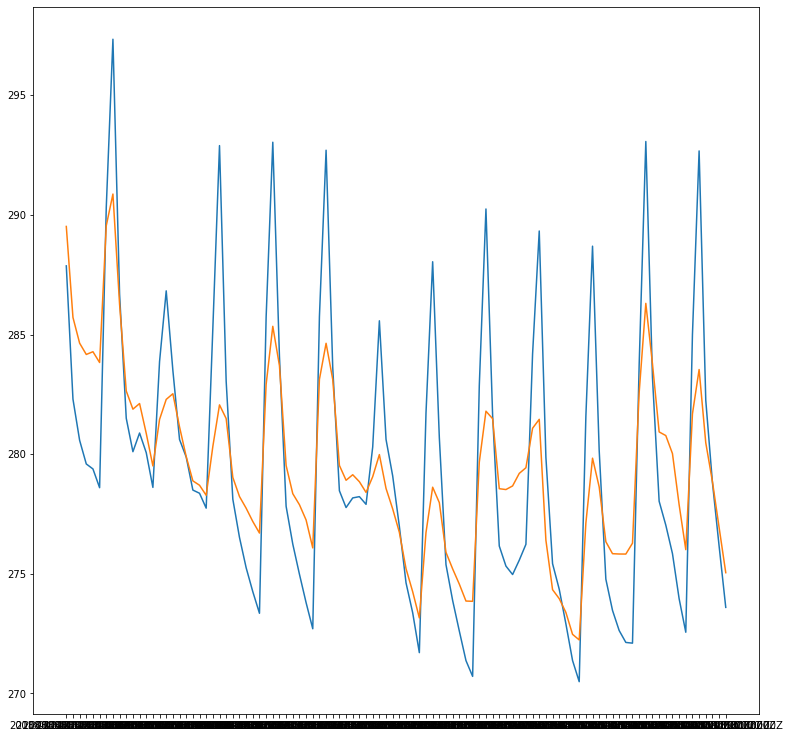

In [7]:
# Plot data to check data is sound

length = 100
x = Data_all['time (UTC)'][0:length]
y = Data_all['tmpsfc (K)'][0:length]
x = Data_all['time (UTC)'][0:length]
y2 = Data_all['tmp2m (K)'][0:length]

plt.figure(figsize=(13,13))
plt.plot(x,y,x,y2)

# Average by day of year

In [8]:
# THe next few cells set time to datetime data type and set the index of the data frame to time

Data_all.rename(columns={'time (UTC)': 'time'}, inplace=True)

In [9]:
Data_all['time'] = pd.to_datetime(Data_all['time'])

In [10]:
Data_all = Data_all.set_index('time')

In [11]:
Data_all.head()

,latitude (degrees_north),longitude (degrees_east),tmpsfc (K),tmp2m (K),ugrd10m (m s-1),vgrd10m (m s-1),pratesfc (kg m-2 s-1),rh2m (%),prmslmsl (Pa),dlwrfsfc (W m-2),dswrfsfc (W m-2)
time,,,,,,,,,,,
2018-01-01 12:00:00+00:00,38.0,58.0,287.87296,289.52072,-1.654617,0.965122,NaN,19.307024,101252.050,NaN,NaN
2018-01-01 15:00:00+00:00,38.0,58.0,282.30330,285.71680,0.030881,1.948872,0.0,23.900000,101214.586,282.00000,10.0
2018-01-01 18:00:00+00:00,38.0,58.0,280.58080,284.64194,0.507683,2.110371,0.0,24.100000,101047.586,276.63098,10.0
2018-01-01 21:00:00+00:00,38.0,58.0,279.59222,284.16950,0.835078,2.283294,0.0,23.300001,100830.130,269.90836,0.0
2018-01-02 00:00:00+00:00,38.0,58.0,279.38390,284.28410,1.225317,2.577678,0.0,22.500000,100611.414,272.36440,0.0


In [12]:
# Calculate the average of the five main components we are interested in by day of year

avg_u = np.array(Data_all.groupby([(Data_all.index.month), (Data_all.index.day)])['ugrd10m (m s-1)'].mean())
avg_v = np.array(Data_all.groupby([(Data_all.index.month), (Data_all.index.day)])['vgrd10m (m s-1)'].mean())
avg_rh = np.array(Data_all.groupby([(Data_all.index.month), (Data_all.index.day)])['rh2m (%)'].mean())
avg_t = np.array(Data_all.groupby([(Data_all.index.month), (Data_all.index.day)])['tmpsfc (K)'].mean())
avg_t2m = np.array(Data_all.groupby([(Data_all.index.month), (Data_all.index.day)])['tmp2m (K)'].mean())
avg_p = np.array(Data_all.groupby([(Data_all.index.month), (Data_all.index.day)])['prmslmsl (Pa)'].mean())

In [13]:
# Converting average np arrays back to pd dataframe

Data_all_avg = pd.date_range(start='1/1/2018', end='12/31/2018', freq='D')
Data_all_avg = pd.DataFrame(Data_all_avg, columns=['time'])
Data_all_avg['ugrd10m (m s-1)'] = pd.DataFrame(avg_u)
Data_all_avg['vgrd10m (m s-1)'] = pd.DataFrame(avg_v)
Data_all_avg['rh2m (%)'] = pd.DataFrame(avg_rh)
Data_all_avg['tmpsfc (K)'] = pd.DataFrame(avg_t)
Data_all_avg['tmp2m (K)'] = pd.DataFrame(avg_t2m)
Data_all_avg['Sea Level Pressure (Pa)'] = pd.DataFrame(avg_p)
Data_all_avg

,time,ugrd10m (m s-1),vgrd10m (m s-1),rh2m (%),tmpsfc (K),tmp2m (K),Sea Level Pressure (Pa)
0,2018-01-01,-0.070244,1.826915,22.651756,282.587320,286.012240,101086.088000
1,2018-01-02,1.269307,0.518547,28.338639,284.354002,285.181348,100613.050500
2,2018-01-03,0.906660,0.850309,60.967446,281.484155,280.822850,101375.239500
3,2018-01-04,0.140965,1.113001,61.667871,280.902554,279.483244,101816.490000
4,2018-01-05,-0.659297,0.921091,46.563653,279.938299,280.202139,101338.338125
...,...,...,...,...,...,...,...
360,2018-12-27,1.725643,3.618721,22.028694,284.481719,286.606084,101563.219500
361,2018-12-28,0.860411,1.187227,29.196002,282.972500,284.470825,101046.371250
362,2018-12-29,0.048003,-1.288886,75.564311,277.513865,275.725635,102211.427000
363,2018-12-30,-2.072063,0.655616,59.826888,276.397744,276.056969,102469.298250


# Functions to Calculate Wind Speed and Direction

In [14]:
# Calculate speed from u and v wind vectors

def speed(u, v):
  spd = np.sqrt(np.square(u) + np.square(v))
  return spd

In [15]:
# Calculate wind direction by finding angle of wind vector

def direction(u, v):
  dir = (270-np.rad2deg(np.arctan2(v,u)))%360
  return dir

# Find Wind Speed and Direction for Data

In [16]:
Data_all_avg.head()

,time,ugrd10m (m s-1),vgrd10m (m s-1),rh2m (%),tmpsfc (K),tmp2m (K),Sea Level Pressure (Pa)
0,2018-01-01,-0.070244,1.826915,22.651756,282.587320,286.012240,101086.088000
1,2018-01-02,1.269307,0.518547,28.338639,284.354002,285.181348,100613.050500
2,2018-01-03,0.906660,0.850309,60.967446,281.484155,280.822850,101375.239500
3,2018-01-04,0.140965,1.113001,61.667871,280.902554,279.483244,101816.490000
4,2018-01-05,-0.659297,0.921091,46.563653,279.938299,280.202139,101338.338125


In [17]:
# Vectorized calculation of wind speed for the northern stations

data_speed = speed(np.array(Data_all_avg['ugrd10m (m s-1)']), np.array(Data_all_avg['vgrd10m (m s-1)']))
data_dir = direction(np.array(Data_all_avg['ugrd10m (m s-1)']), np.array(Data_all_avg['vgrd10m (m s-1)']))

In [18]:
# Convert array to dataframe and add to north station data

data_speed_df = pd.DataFrame(data=data_speed, columns=['Wind Speed (m/s)'])
data_dir_df = pd.DataFrame(data=data_dir, columns=['Wind Dir'])

Data_all_avg['Wind Speed (m/s)'] = data_speed_df
Data_all_avg['Wind Dir'] = data_dir_df

In [19]:
Data_all_avg.head()

,time,ugrd10m (m s-1),vgrd10m (m s-1),rh2m (%),tmpsfc (K),tmp2m (K),Sea Level Pressure (Pa),Wind Speed (m/s),Wind Dir
0,2018-01-01,-0.070244,1.826915,22.651756,282.587320,286.012240,101086.088000,1.828265,177.798104
1,2018-01-02,1.269307,0.518547,28.338639,284.354002,285.181348,100613.050500,1.371142,247.778608
2,2018-01-03,0.906660,0.850309,60.967446,281.484155,280.822850,101375.239500,1.243004,226.837023
3,2018-01-04,0.140965,1.113001,61.667871,280.902554,279.483244,101816.490000,1.121892,187.218237
4,2018-01-05,-0.659297,0.921091,46.563653,279.938299,280.202139,101338.338125,1.132732,144.405745


In [20]:
Data_all_avg['Wind Speed (m/s)'].dropna

<bound method Series.dropna of 0      1.828265
1      1.371142
2      1.243004
3      1.121892
4      1.132732
         ...   
360    4.009113
361    1.466225
362    1.289780
363    2.173310
364    1.373115
Name: Wind Speed (m/s), Length: 365, dtype: float64>

In [21]:
Data_all_avg

,time,ugrd10m (m s-1),vgrd10m (m s-1),rh2m (%),tmpsfc (K),tmp2m (K),Sea Level Pressure (Pa),Wind Speed (m/s),Wind Dir
0,2018-01-01,-0.070244,1.826915,22.651756,282.587320,286.012240,101086.088000,1.828265,177.798104
1,2018-01-02,1.269307,0.518547,28.338639,284.354002,285.181348,100613.050500,1.371142,247.778608
2,2018-01-03,0.906660,0.850309,60.967446,281.484155,280.822850,101375.239500,1.243004,226.837023
3,2018-01-04,0.140965,1.113001,61.667871,280.902554,279.483244,101816.490000,1.121892,187.218237
4,2018-01-05,-0.659297,0.921091,46.563653,279.938299,280.202139,101338.338125,1.132732,144.405745
...,...,...,...,...,...,...,...,...,...
360,2018-12-27,1.725643,3.618721,22.028694,284.481719,286.606084,101563.219500,4.009113,205.494867
361,2018-12-28,0.860411,1.187227,29.196002,282.972500,284.470825,101046.371250,1.466225,215.931724
362,2018-12-29,0.048003,-1.288886,75.564311,277.513865,275.725635,102211.427000,1.289780,357.867091
363,2018-12-30,-2.072063,0.655616,59.826888,276.397744,276.056969,102469.298250,2.173310,107.557766


# Convert wind speed from measurement at 10m to 60m

Use the wind shear equation https://www.engineeringtoolbox.com/wind-shear-d_1215.html 

where:

alpha = .25 for hills
vo = calculated wind speed (m/s)
v = solving for
ho = 10m
h = 60m

In [22]:
# Setup variables
alpha = .25
h_orig = 10
h_final = 60

In [23]:
# Calc wind speed @ 60m

v_final = np.array(Data_all_avg['Wind Speed (m/s)']) * (h_final/h_orig)**alpha
Data_all_avg['Wind Speed (m/s) @ 60m'] = pd.DataFrame(v_final)

In [24]:
Data_all_avg.head()

,time,ugrd10m (m s-1),vgrd10m (m s-1),rh2m (%),tmpsfc (K),tmp2m (K),Sea Level Pressure (Pa),Wind Speed (m/s),Wind Dir,Wind Speed (m/s) @ 60m
0,2018-01-01,-0.070244,1.826915,22.651756,282.587320,286.012240,101086.088000,1.828265,177.798104,2.861389
1,2018-01-02,1.269307,0.518547,28.338639,284.354002,285.181348,100613.050500,1.371142,247.778608,2.145953
2,2018-01-03,0.906660,0.850309,60.967446,281.484155,280.822850,101375.239500,1.243004,226.837023,1.945406
3,2018-01-04,0.140965,1.113001,61.667871,280.902554,279.483244,101816.490000,1.121892,187.218237,1.755856
4,2018-01-05,-0.659297,0.921091,46.563653,279.938299,280.202139,101338.338125,1.132732,144.405745,1.772821


# Calculated Potential Power Output

In [25]:
# Power output equation can be found in paper, equal to P (Watts) = .5 * densityofair * Rotorsweptarea * velocty**3

air_density = 1.225

# Rotor radius for High Winds project is 40 meters (Vestas V80-1.8 turbine)

swept_area = math.pi * (40**2)

In [26]:
# Now calculate the power output for each day and add as new column on dataframe

power = .5 * air_density * swept_area * np.array(Data_all_avg['Wind Speed (m/s) @ 60m'])**3
Data_all_avg['Power (W)'] = pd.DataFrame(power)

In [27]:
Data_all_avg.head()

,time,ugrd10m (m s-1),vgrd10m (m s-1),rh2m (%),tmpsfc (K),tmp2m (K),Sea Level Pressure (Pa),Wind Speed (m/s),Wind Dir,Wind Speed (m/s) @ 60m,Power (W)
0,2018-01-01,-0.070244,1.826915,22.651756,282.587320,286.012240,101086.088000,1.828265,177.798104,2.861389,72128.432829
1,2018-01-02,1.269307,0.518547,28.338639,284.354002,285.181348,100613.050500,1.371142,247.778608,2.145953,30425.434154
2,2018-01-03,0.906660,0.850309,60.967446,281.484155,280.822850,101375.239500,1.243004,226.837023,1.945406,22667.664700
3,2018-01-04,0.140965,1.113001,61.667871,280.902554,279.483244,101816.490000,1.121892,187.218237,1.755856,16666.443001
4,2018-01-05,-0.659297,0.921091,46.563653,279.938299,280.202139,101338.338125,1.132732,144.405745,1.772821,17154.210999


In [28]:
# Now multiply that power by 90 to get total potential output from high winds farm

power_all = (np.array(Data_all_avg['Power (W)']) * 90) / 1000000
Data_all_avg['Power All (MW)'] = pd.DataFrame(power_all)

In [29]:
Data_all_avg.head()

,time,ugrd10m (m s-1),vgrd10m (m s-1),rh2m (%),tmpsfc (K),tmp2m (K),Sea Level Pressure (Pa),Wind Speed (m/s),Wind Dir,Wind Speed (m/s) @ 60m,Power (W),Power All (MW)
0,2018-01-01,-0.070244,1.826915,22.651756,282.587320,286.012240,101086.088000,1.828265,177.798104,2.861389,72128.432829,6.491559
1,2018-01-02,1.269307,0.518547,28.338639,284.354002,285.181348,100613.050500,1.371142,247.778608,2.145953,30425.434154,2.738289
2,2018-01-03,0.906660,0.850309,60.967446,281.484155,280.822850,101375.239500,1.243004,226.837023,1.945406,22667.664700,2.040090
3,2018-01-04,0.140965,1.113001,61.667871,280.902554,279.483244,101816.490000,1.121892,187.218237,1.755856,16666.443001,1.499980
4,2018-01-05,-0.659297,0.921091,46.563653,279.938299,280.202139,101338.338125,1.132732,144.405745,1.772821,17154.210999,1.543879


In [30]:
# Calculating the Capacity Factor based on 1.8 MW rating

capacity = np.round(((np.array(Data_all_avg['Power (W)']))/ 1800000) * 100,1)
Data_all_avg['Capacity (%)'] = pd.DataFrame(capacity)

In [31]:
Data_all_avg.head()

,time,ugrd10m (m s-1),vgrd10m (m s-1),rh2m (%),tmpsfc (K),tmp2m (K),Sea Level Pressure (Pa),Wind Speed (m/s),Wind Dir,Wind Speed (m/s) @ 60m,Power (W),Power All (MW),Capacity (%)
0,2018-01-01,-0.070244,1.826915,22.651756,282.587320,286.012240,101086.088000,1.828265,177.798104,2.861389,72128.432829,6.491559,4.0
1,2018-01-02,1.269307,0.518547,28.338639,284.354002,285.181348,100613.050500,1.371142,247.778608,2.145953,30425.434154,2.738289,1.7
2,2018-01-03,0.906660,0.850309,60.967446,281.484155,280.822850,101375.239500,1.243004,226.837023,1.945406,22667.664700,2.040090,1.3
3,2018-01-04,0.140965,1.113001,61.667871,280.902554,279.483244,101816.490000,1.121892,187.218237,1.755856,16666.443001,1.499980,0.9
4,2018-01-05,-0.659297,0.921091,46.563653,279.938299,280.202139,101338.338125,1.132732,144.405745,1.772821,17154.210999,1.543879,1.0


# Number of days over the 1.8 MW Capacity of individual turbines or 162 MW Capacity of Farm

In [32]:
Data_all_avg_over_cap = Data_all_avg[Data_all_avg['Power (W)'] > 1800000]

In [33]:
Data_all_avg_over_cap

,time,ugrd10m (m s-1),vgrd10m (m s-1),rh2m (%),tmpsfc (K),tmp2m (K),Sea Level Pressure (Pa),Wind Speed (m/s),Wind Dir,Wind Speed (m/s) @ 60m,Power (W),Power All (MW),Capacity (%)
147,2018-05-28,35.640738,0.071374,32.379615,262.102538,294.526473,89231.8245,35.64081,269.88526,55.780882,5.343577e+08,48092.193027,29686.5


In [34]:
Data_all_avg_over_cap2 = Data_all_avg[Data_all_avg['Power All (MW)'] > 162]

In [35]:
Data_all_avg_over_cap2

,time,ugrd10m (m s-1),vgrd10m (m s-1),rh2m (%),tmpsfc (K),tmp2m (K),Sea Level Pressure (Pa),Wind Speed (m/s),Wind Dir,Wind Speed (m/s) @ 60m,Power (W),Power All (MW),Capacity (%)
147,2018-05-28,35.640738,0.071374,32.379615,262.102538,294.526473,89231.8245,35.64081,269.88526,55.780882,5.343577e+08,48092.193027,29686.5


# Calcualte MWh

Another way to estimate is find out how many hours to assume generate power with wind over course of year and use above power value. From this link https://www.wind-watch.org/faq-output.php can assume that power is generated around 40% of the time.

In [36]:
# Filter for days above 3 m/s and below 15 m/s

Data_all_avg_elec = Data_all_avg[Data_all_avg['Wind Speed (m/s)'] >= 0]
Data_all_avg_elec = Data_all_avg_elec[Data_all_avg_elec['Wind Speed (m/s)'] < 15]
new_index = np.arange(len(Data_all_avg_elec))
Data_all_avg_elec = Data_all_avg_elec.reset_index()
Data_all_avg_elec

,index,time,ugrd10m (m s-1),vgrd10m (m s-1),rh2m (%),tmpsfc (K),tmp2m (K),Sea Level Pressure (Pa),Wind Speed (m/s),Wind Dir,Wind Speed (m/s) @ 60m,Power (W),Power All (MW),Capacity (%)
0,0,2018-01-01,-0.070244,1.826915,22.651756,282.587320,286.012240,101086.088000,1.828265,177.798104,2.861389,72128.432829,6.491559,4.0
1,1,2018-01-02,1.269307,0.518547,28.338639,284.354002,285.181348,100613.050500,1.371142,247.778608,2.145953,30425.434154,2.738289,1.7
2,2,2018-01-03,0.906660,0.850309,60.967446,281.484155,280.822850,101375.239500,1.243004,226.837023,1.945406,22667.664700,2.040090,1.3
3,3,2018-01-04,0.140965,1.113001,61.667871,280.902554,279.483244,101816.490000,1.121892,187.218237,1.755856,16666.443001,1.499980,0.9
4,4,2018-01-05,-0.659297,0.921091,46.563653,279.938299,280.202139,101338.338125,1.132732,144.405745,1.772821,17154.210999,1.543879,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359,360,2018-12-27,1.725643,3.618721,22.028694,284.481719,286.606084,101563.219500,4.009113,205.494867,6.274600,760561.166451,68.450505,42.3
360,361,2018-12-28,0.860411,1.187227,29.196002,282.972500,284.470825,101046.371250,1.466225,215.931724,2.294766,37204.146601,3.348373,2.1
361,362,2018-12-29,0.048003,-1.288886,75.564311,277.513865,275.725635,102211.427000,1.289780,357.867091,2.018615,25324.230737,2.279181,1.4
362,363,2018-12-30,-2.072063,0.655616,59.826888,276.397744,276.056969,102469.298250,2.173310,107.557766,3.401414,121158.704535,10.904283,6.7


In [37]:
# Assume that it is operating at 40% of the time

electricity_all = (np.array(Data_all_avg_elec['Power All (MW)']) * 24 * .4)
Data_all_avg_elec['Electricity All (MWh)'] = pd.DataFrame(electricity_all)
Data_all_avg_elec.head()

,index,time,ugrd10m (m s-1),vgrd10m (m s-1),rh2m (%),tmpsfc (K),tmp2m (K),Sea Level Pressure (Pa),Wind Speed (m/s),Wind Dir,Wind Speed (m/s) @ 60m,Power (W),Power All (MW),Capacity (%),Electricity All (MWh)
0,0,2018-01-01,-0.070244,1.826915,22.651756,282.587320,286.012240,101086.088000,1.828265,177.798104,2.861389,72128.432829,6.491559,4.0,62.318966
1,1,2018-01-02,1.269307,0.518547,28.338639,284.354002,285.181348,100613.050500,1.371142,247.778608,2.145953,30425.434154,2.738289,1.7,26.287575
2,2,2018-01-03,0.906660,0.850309,60.967446,281.484155,280.822850,101375.239500,1.243004,226.837023,1.945406,22667.664700,2.040090,1.3,19.584862
3,3,2018-01-04,0.140965,1.113001,61.667871,280.902554,279.483244,101816.490000,1.121892,187.218237,1.755856,16666.443001,1.499980,0.9,14.399807
4,4,2018-01-05,-0.659297,0.921091,46.563653,279.938299,280.202139,101338.338125,1.132732,144.405745,1.772821,17154.210999,1.543879,1.0,14.821238


In [38]:
# Sum up for all of the days

electricity_2018 = Data_all_avg_elec.sum(axis=0)['Electricity All (MWh)']
electricity_2018

38964.56221927689

In [39]:
# Assuming operation 100% of the time

electricity_all = (np.array(Data_all_avg['Power All (MW)']) * 24)
Data_all_avg['Electricity All (MWh)'] = pd.DataFrame(electricity_all)

In [40]:
Data_all_avg.head()

,time,ugrd10m (m s-1),vgrd10m (m s-1),rh2m (%),tmpsfc (K),tmp2m (K),Sea Level Pressure (Pa),Wind Speed (m/s),Wind Dir,Wind Speed (m/s) @ 60m,Power (W),Power All (MW),Capacity (%),Electricity All (MWh)
0,2018-01-01,-0.070244,1.826915,22.651756,282.587320,286.012240,101086.088000,1.828265,177.798104,2.861389,72128.432829,6.491559,4.0,155.797415
1,2018-01-02,1.269307,0.518547,28.338639,284.354002,285.181348,100613.050500,1.371142,247.778608,2.145953,30425.434154,2.738289,1.7,65.718938
2,2018-01-03,0.906660,0.850309,60.967446,281.484155,280.822850,101375.239500,1.243004,226.837023,1.945406,22667.664700,2.040090,1.3,48.962156
3,2018-01-04,0.140965,1.113001,61.667871,280.902554,279.483244,101816.490000,1.121892,187.218237,1.755856,16666.443001,1.499980,0.9,35.999517
4,2018-01-05,-0.659297,0.921091,46.563653,279.938299,280.202139,101338.338125,1.132732,144.405745,1.772821,17154.210999,1.543879,1.0,37.053096


In [41]:
# Outlier Electricity

electricity_0528 = Data_all_avg.iloc[147]['Electricity All (MWh)']

In [42]:
# Caculating the total MWh for the year 2018

electricity_2018 = Data_all_avg.sum(axis=0)['Electricity All (MWh)']
electricity_2018

1251624.0381847534

In [43]:
# Removing outlier, above turbine capacity

electricity_2018 = electricity_2018 - electricity_0528
electricity_2018

97411.4055481921

# Distribution of Capacity

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


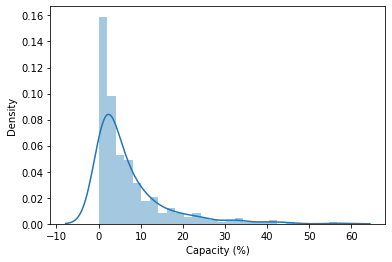

In [44]:
# Histogram of capacity across 2018

seaborn.distplot(Data_all_avg_elec['Capacity (%)'])

# Wind Direction

In [45]:
Data_all_avg_elec.head()

,index,time,ugrd10m (m s-1),vgrd10m (m s-1),rh2m (%),tmpsfc (K),tmp2m (K),Sea Level Pressure (Pa),Wind Speed (m/s),Wind Dir,Wind Speed (m/s) @ 60m,Power (W),Power All (MW),Capacity (%),Electricity All (MWh)
0,0,2018-01-01,-0.070244,1.826915,22.651756,282.587320,286.012240,101086.088000,1.828265,177.798104,2.861389,72128.432829,6.491559,4.0,62.318966
1,1,2018-01-02,1.269307,0.518547,28.338639,284.354002,285.181348,100613.050500,1.371142,247.778608,2.145953,30425.434154,2.738289,1.7,26.287575
2,2,2018-01-03,0.906660,0.850309,60.967446,281.484155,280.822850,101375.239500,1.243004,226.837023,1.945406,22667.664700,2.040090,1.3,19.584862
3,3,2018-01-04,0.140965,1.113001,61.667871,280.902554,279.483244,101816.490000,1.121892,187.218237,1.755856,16666.443001,1.499980,0.9,14.399807
4,4,2018-01-05,-0.659297,0.921091,46.563653,279.938299,280.202139,101338.338125,1.132732,144.405745,1.772821,17154.210999,1.543879,1.0,14.821238


In [46]:
# Assigning a Direction

wind_dir_data = (np.array(Data_all_avg['Wind Dir']))

# Create empty list
wind_dir_data_comp = []

for i in range(len(wind_dir_data)):
  degrees = wind_dir_data[i]

  if degrees < 22.5 or degrees > 337.5:
    compass = 'N'
  elif 22.5 < degrees < 67.5:
    compass = 'NE'
  elif 67.5 < degrees < 112.5:
    compass = 'E'
  elif 112.5 < degrees < 157.5:
    compass = 'SE'
  elif 157.5 < degrees < 202.5:
    compass = 'S'
  elif 202.5 < degrees < 247.5:
    compass = 'SW'
  elif 247.5 < degrees < 292.5:
    compass = 'W'
  elif 292.5 < degrees < 337.5:
    compass = 'NW'
  
  wind_dir_data_comp.append(compass)

In [47]:
# Add back to dataframe

Data_all_avg_elec['Compass Direction'] = pd.DataFrame(wind_dir_data_comp)

In [48]:
Data_all_avg_elec.iloc[45:60]

,index,time,ugrd10m (m s-1),vgrd10m (m s-1),rh2m (%),tmpsfc (K),tmp2m (K),Sea Level Pressure (Pa),Wind Speed (m/s),Wind Dir,Wind Speed (m/s) @ 60m,Power (W),Power All (MW),Capacity (%),Electricity All (MWh),Compass Direction
45,45,2018-02-15,-1.692253,0.493121,70.096687,276.958489,275.772625,103052.515250,1.762637,106.246072,2.758676,64636.546970,5.817289,3.6,55.845977,E
46,46,2018-02-16,-1.380809,-0.335902,58.274145,284.263140,282.472774,101130.219000,1.421078,76.327543,2.224108,33872.197960,3.048498,1.9,29.265579,E
47,47,2018-02-17,-0.278895,-0.838226,71.743886,283.104051,279.505044,101684.859875,0.883405,18.403340,1.382604,8137.099976,0.732339,0.5,7.030454,N
48,48,2018-02-18,-1.481899,0.211778,65.789722,282.267715,279.394437,102078.933000,1.496955,98.133071,2.342862,39592.773735,3.563350,2.2,34.208157,E
49,49,2018-02-19,-1.453068,-0.946301,63.004655,282.982880,281.328760,101664.338125,1.734039,56.926091,2.713918,61541.225423,5.538710,3.4,53.171619,NE
50,50,2018-02-20,-0.848007,-0.673513,71.962422,282.663995,279.091084,101943.959125,1.082929,51.542350,1.694876,14989.579171,1.349062,0.8,12.950996,NE
51,51,2018-02-21,-1.836309,-0.088553,60.235809,282.685560,280.428044,101965.365250,1.838443,87.239130,2.877319,73339.861660,6.600588,4.1,63.365640,E
52,52,2018-02-22,-2.004092,0.061330,51.906039,283.504732,281.697763,101577.931250,2.005030,91.752848,3.138042,95137.575385,8.562382,5.3,82.198865,E
53,53,2018-02-23,-1.062180,-0.736340,59.553524,283.313250,280.863766,101442.487250,1.292448,55.268948,2.022791,25481.716922,2.293355,1.4,22.016203,NE
54,54,2018-02-24,-2.340973,0.343789,65.033904,284.511284,282.212795,101328.395625,2.366082,98.354595,3.703118,156343.095029,14.070879,8.7,135.080434,E


In [49]:
# Create Barchart of Directions

compass_counts = pd.value_counts(Data_all_avg_elec['Compass Direction']).to_frame().reset_index()

In [50]:
compass_counts.columns = ['Compass Direction', 'Count']

In [51]:
compass_counts

,Compass Direction,Count
0,E,131
1,NE,75
2,N,65
3,SE,27
4,S,19
5,SW,19
6,NW,18
7,W,10


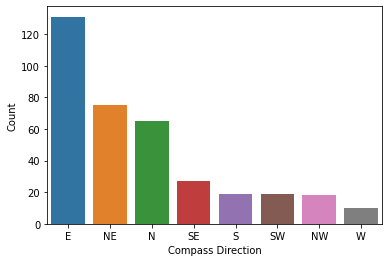

In [52]:
seaborn.barplot(x=compass_counts['Compass Direction'], y=compass_counts['Count'])

# Plotting

In [53]:
def plot_variable(days, variable, label):
    fig = plt.figure(figsize=(17,8))

    plt.plot(days, variable, label=label, color='green', linewidth='2')
    plt.title(label)
    plt.ylabel(label)
    plt.xlabel('Days')

    plt.legend()
    plt.show()

In [54]:
def plot_overlay(days, variable, days2, variable2, label):
    fig = plt.figure(figsize=(17,8))

    plt.plot(days, variable, label=label, color='blue', linewidth='2')
    plt.plot(days2, variable2, label='Capacity', color='red', linewidth='2')
    plt.title(label)
    plt.ylabel(label)
    plt.xlabel('Days')

    plt.legend()
    plt.show()

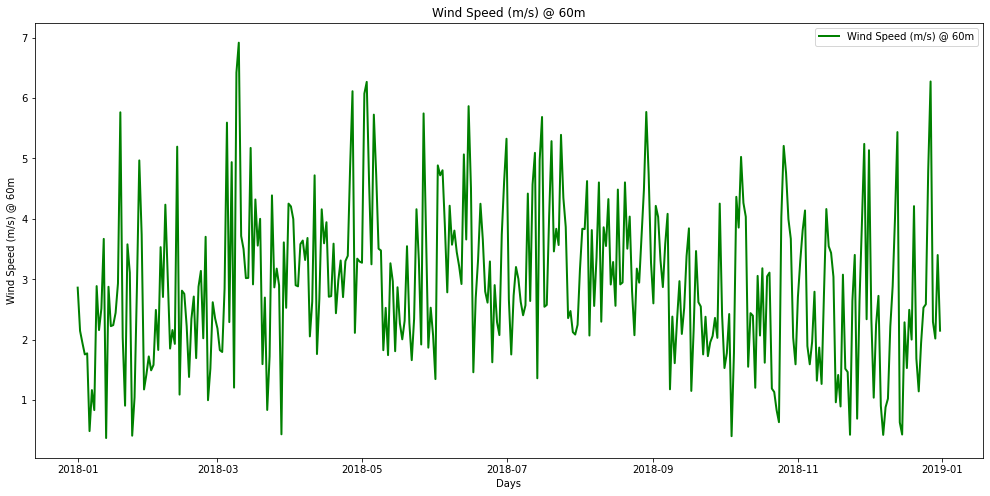

In [55]:
x = 365
outliers = [147]

plot_variable(Data_all_avg['time'][0:x].drop(axis=0, index=outliers), Data_all_avg['Wind Speed (m/s) @ 60m'][0:x].drop(axis=0, index=outliers), 'Wind Speed (m/s) @ 60m')

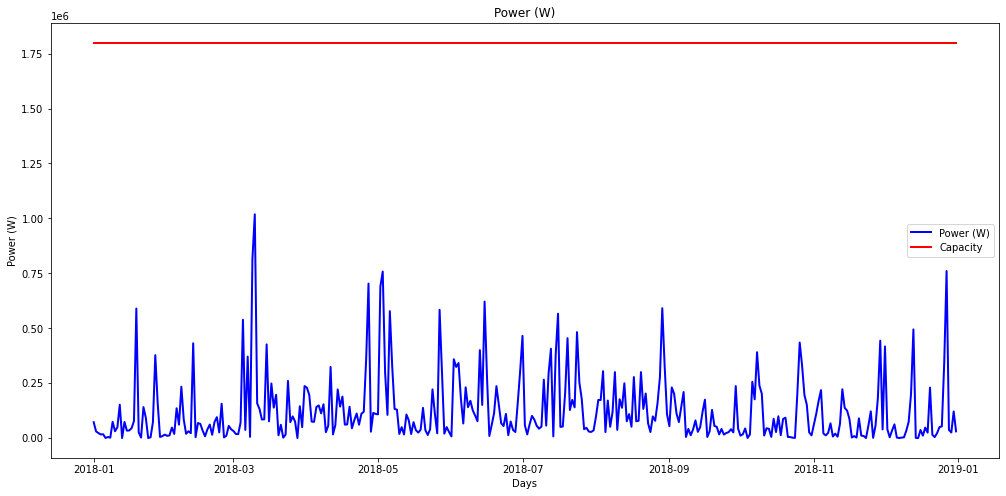

In [56]:
x = 365
outliers = [147]

plot_overlay(Data_all_avg['time'][0:x].drop(axis=0, index=outliers), Data_all_avg['Power (W)'][0:x].drop(axis=0, index=outliers), Data_all_avg['time'][0:x].drop(axis=0, index=outliers), np.full((len(Data_all_avg)-len(outliers),), 1800000), 'Power (W)')

In [57]:
# Maybe use seaborn to have multiple axis and get better results

def plot_variables(windspeed, power, temp2, rh, pres):
    fig, axs = plt.subplots(3,2,figsize=(20,10))

    axs[0,0].plot(windspeed, label='wind speed (m/s) @ 60m', color='green', linewidth='2')
    axs[0,0].set_title('Wind Speed')
    axs[0,0].set_ylabel('Wind Speed (m/s)')

    axs[0,1].plot(power, label='power all (MW)', color='red', linewidth='2')
    axs[0,1].set_title('Power')
    axs[0,1].set_ylabel('Power All (MW)')

    axs[1,0].plot(temp2, label='temp @ 2m (K)', color='orange', linewidth='2')
    axs[1,0].set_title('Temp @ 2m')
    axs[1,0].set_ylabel('Temp (K)')

    axs[1,1].plot(rh, label='relative humidity', color='blue', linewidth='2')
    axs[1,1].set_title('Relative Humidity @ 2m')
    axs[1,1].set_ylabel('Relative Humidity')

    axs[2,0].plot(pres, label='pressure (Pa)', color='purple', linewidth='2')
    axs[2,0].set_title('Sea Level Pressure')
    axs[2,0].set_ylabel('Sea Level Pressure (Pa)')

    plt.show()

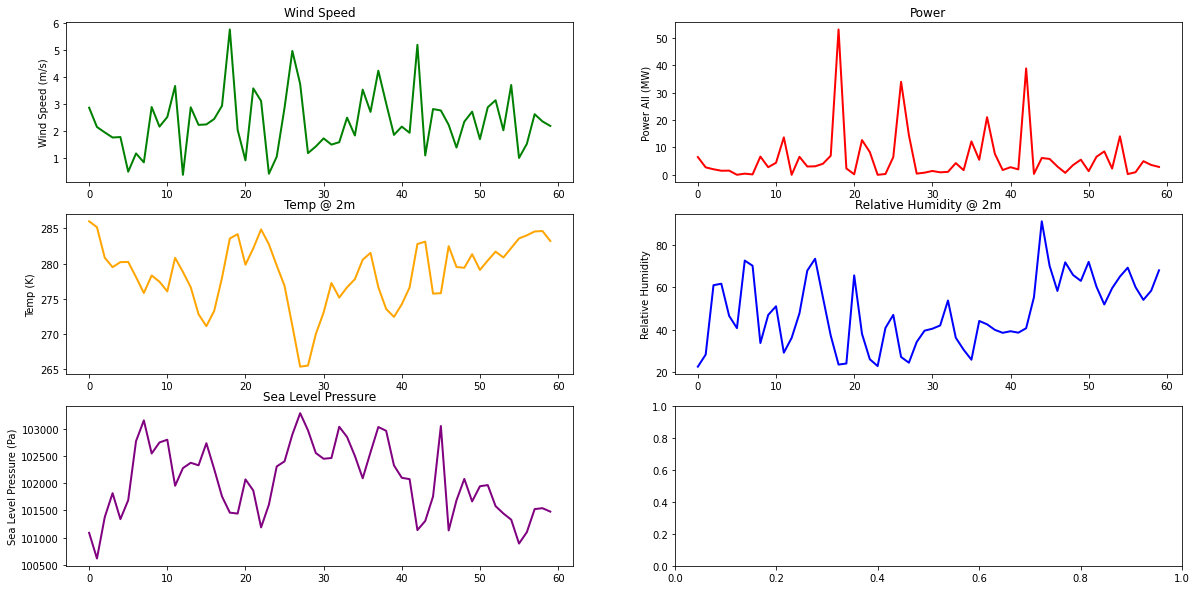

In [58]:
#days
x1=0
x2=60
outliers = [147]

if x2 < 147 or x1 > 147:
  plot_variables(Data_all_avg['Wind Speed (m/s) @ 60m'][x1:x2], Data_all_avg['Power All (MW)'][x1:x2], Data_all_avg['tmp2m (K)'][x1:x2], Data_all_avg['rh2m (%)'][x1:x2], Data_all_avg['Sea Level Pressure (Pa)'][x1:x2])
else:
  plot_variables(Data_all_avg['Wind Speed (m/s) @ 60m'][0:x].drop(axis=0, index=outliers), Data_all_avg['Power All (MW)'][0:x].drop(axis=0, index=outliers), Data_all_avg['tmp2m (K)'][0:x].drop(axis=0,index=outliers),\
                 Data_all_avg['rh2m (%)'][0:x].drop(axis=0, index=outliers), Data_all_avg['Sea Level Pressure (Pa)'][0:x].drop(axis=0, index=outliers))

In [59]:
# Maybe use seaborn to have multiple axis and get better results

def plot_variables2(windspeed, temp2, rh):
    fig, axs = plt.subplots(2,2,figsize=(20,10))

    axs[0,0].plot(windspeed, label='wind speed (m/s) @ 60m', color='green', linewidth='2')
    axs[0,0].set_title('Wind Speed')
    axs[0,0].set_ylabel('Wind Speed (m/s)')

    axs[1,0].plot(temp2, label='temp @ 2m (K)', color='orange', linewidth='2')
    axs[1,0].set_title('Temp @ 2m')
    axs[1,0].set_ylabel('Temp (K)')

    axs[0,1].plot(windspeed, label='wind speed (m/s) @ 60m', color='green', linewidth='2')
    axs[0,1].set_title('Wind Speed')
    axs[0,1].set_ylabel('Wind Speed (m/s)')

    axs[1,1].plot(rh, label='relative humidity', color='blue', linewidth='2')
    axs[1,1].set_title('Relative Humidity @ 2m')
    axs[1,1].set_ylabel('Relative Humidity')

    plt.show()

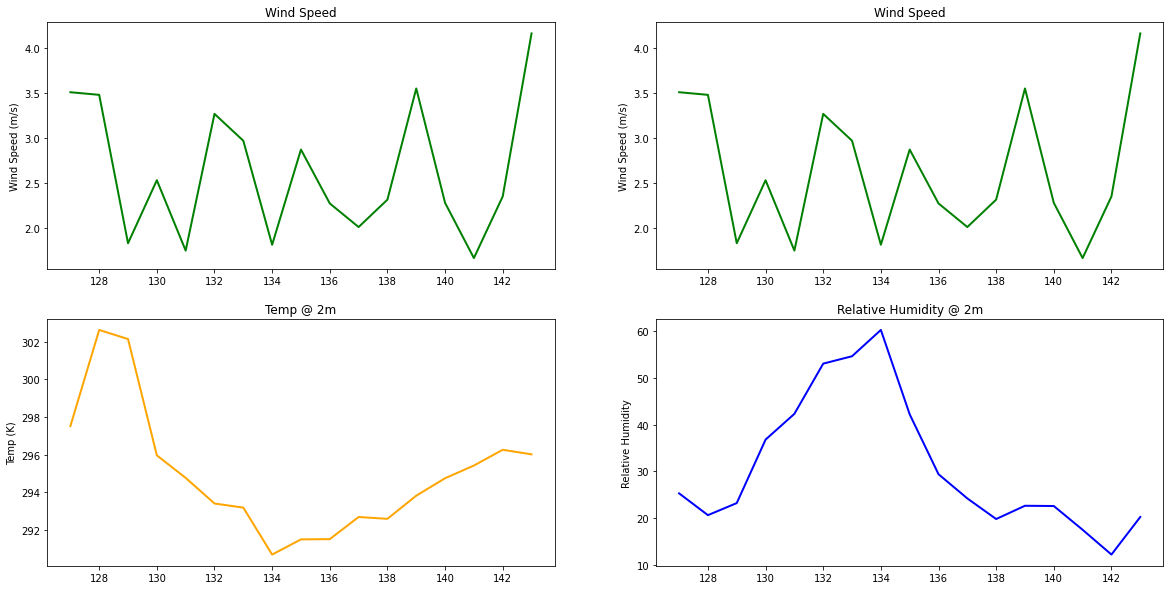

In [62]:
#days
x1=127
x2=144
outliers = [147]

if x2 < 147 or x1 > 147:
  plot_variables2(Data_all_avg['Wind Speed (m/s) @ 60m'][x1:x2], Data_all_avg['tmp2m (K)'][x1:x2], Data_all_avg['rh2m (%)'][x1:x2])
else:
  plot_variables2(Data_all_avg['Wind Speed (m/s) @ 60m'][0:x].drop(axis=0, index=outliers),Data_all_avg['tmp2m (K)'][0:x].drop(axis=0,index=outliers),\
                 Data_all_avg['rh2m (%)'][0:x].drop(axis=0, index=outliers))